# MOGDx 

In [21]:
import pandas as pd
import numpy as np
import os
import sys 

sys.path.insert(0 , './../')
from MAIN.utils import *
from MAIN.train import *
import MAIN.preprocess_functions
from MAIN.GNN_MME import GCN_MME

from Modules.PNetTorch.MAIN.reactome import ReactomeNetwork
from Modules.PNetTorch.MAIN.Pnet import MaskedLinear , PNET
from Modules.PNetTorch.MAIN.utils import numpy_array_to_one_hot, get_gpu_memory

import torch
import torch.nn.functional as F
import dgl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import networkx as nx
from datetime import datetime
import joblib
import warnings
import gc

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")

print("Finished Library Import \n")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Finished Library Import 



In [22]:
data_input = './../../data/raw/'
snf_net = 'RPPA_mRNA_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

In [23]:
# List of cancer genes was taken from the PNet paper dataset
genes = pd.read_csv('./../../data/ext_data/cancer_genes.txt', header=0)

# Build network to obtain gene and pathway relationships
net = ReactomeNetwork(genes_of_interest=np.unique(list(genes['genes'].values)) , n_levels=5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

graph_file = data_input + '../Networks/' + snf_net
g = nx.read_graphml(graph_file)

meta = meta.loc[sorted(meta.index)]
label = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64))

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

MME_input_shapes = [ datModalities[mod].shape[1] for mod in datModalities]

h = reduce(merge_dfs , list(datModalities.values()))
h = h.loc[sorted(h.index)]

g = dgl.from_networkx(g , node_attrs=['idx' , 'label'])

g.ndata['feat'] = torch.Tensor(h.to_numpy())

g.ndata['label'] = label

del datModalities
gc.collect()

output_metrics = []
test_logits = []
test_labels = []
for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :

    model = GCN_MME(MME_input_shapes , [16 , 32] , 32 , [16]  , len(meta.unique()), PNet=net).to(device)
    
    print(model)
    print(g)
    
    g = g.to(device)

    loss_plot = train(g, train_index, device ,  model , label , 2000 , 1e-3 , 100)
    plt.title(f'Loss for split {i}')
    plt.show()
    plt.clf()
    
    sampler = NeighborSampler(
        [15 for i in range(len(model.gnnlayers))],  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-2])
    test_labels.extend(test_output_metrics[-1])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)
    
accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
node_true        = []
display_label = meta.astype('category').cat.categories
for pred , true in zip(all_predictions_conf.argmax(1) , list(test_labels.detach().cpu().argmax(1).numpy()))  : 
    node_predictions.append(display_label[pred])
    node_true.append(display_label[true])

tst = pd.DataFrame({'Actual' : node_true , 'Predicted' : node_predictions})

Using cuda device
Total = 6.4Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): PNET(
      (dropout): Dropout(p=0.5, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=464, out_features=723, bias=True)
        (1): MaskedLinear(in_features=723, out_features=1613, bias=True)
        (2): MaskedLinear(in_features=1613, out_features=1107, bias=True)
        (3): MaskedLinear(in_features=1107, out_features=488, bias=True)
        (4): MaskedLinear(in_features=488, out_features=159, bias=True)
        (5): MaskedLinear(in_features=159, out_features=28, bias=True)
      )
      (skip): ModuleList(
        (0): Linear(in_features=723, out_features=32, bias=True)
        (1): Linear(in_features=1613, out_features=32, bias=True)
        (2): Linear(in_features=1107, out_features=32, bias=True)
        (3): Linear(in_features=488, out_features=32, bias=True)
        (4): L

In [5]:
otal = 6.4Gb 	 Reserved = 1.4Gb 	 Allocated = 0.7Gb
Clearing gpu memory
Total = 6.4Gb 	 Reserved = 0.8Gb 	 Allocated = 0.6Gb
5 Fold Cross Validation Accuracy = 85.87 ± 2.19
5 Fold Cross Validation F1 = 83.20 ± 2.62

SyntaxError: invalid syntax (190061122.py, line 1)

In [5]:
get_gpu_memory()
#del model , train_loader , test_loader
torch.cuda.reset_accumulated_memory_stats()
gc.collect()
torch.cuda.empty_cache()
get_gpu_memory()

Total = 6.4Gb 	 Reserved = 0.7Gb 	 Allocated = 0.4Gb
Total = 6.4Gb 	 Reserved = 0.7Gb 	 Allocated = 0.4Gb


In [6]:
# test the model
print("Testing...")
acc = layerwise_infer(
    device, g, np.arange(len(g.nodes())), best_model, batch_size=4096
)
print("Test Accuracy {:.4f}".format(acc.item()))

Testing...
0


100%|██████████| 1/1 [00:00<00:00, 33.02it/s]


1


100%|██████████| 1/1 [00:00<00:00, 32.90it/s]

Test Accuracy 0.9043


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


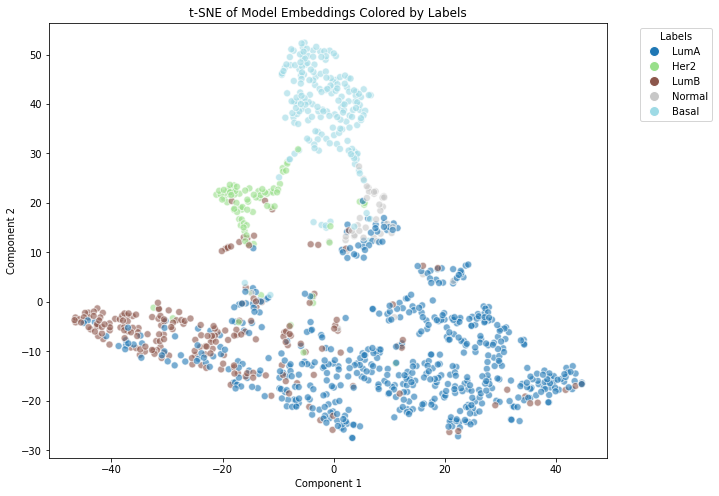

In [7]:
best_model.eval()
with torch.no_grad():
    emb = best_model.embedding_extraction(
        g, g.ndata['feat'] ,device, 4096
    )  # pred in buffer_device

tsne_embedding_plot(emb.detach().cpu().numpy() , meta)

In [9]:
from interpret import interpret , evaluate_interpret_save

In [ ]:
datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

best_model.encoder_dims[0].features = datModalities['RPPA'].columns

h_torch = torch.Tensor(h.values)
x = h_torch[: , :464]
n = x.shape[0]
nan_rows = torch.isnan(x).any(dim=1)
test_data = x[~nan_rows].to(device)

model_importances = interpret(best_model.encoder_dims[0] , test_data , savedir='None')

Save Path Not Found - Plots will not be saved


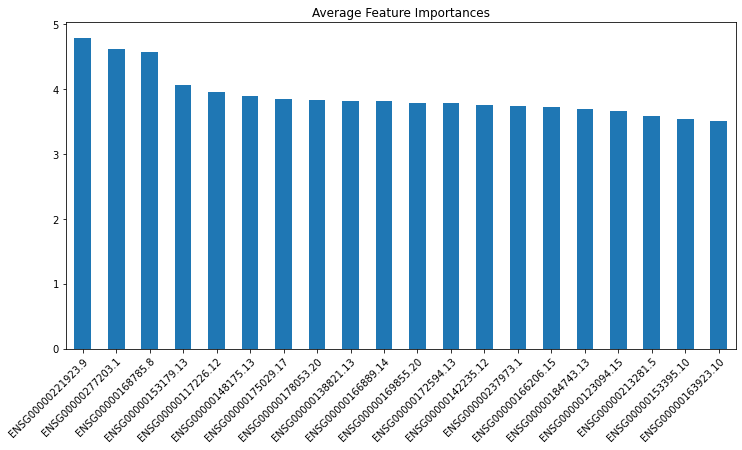

Linear(in_features=29995, out_features=723, bias=True)
MaskedLinear(in_features=723, out_features=1613, bias=True)
MaskedLinear(in_features=1613, out_features=1107, bias=True)


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.97 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 13.04 GiB is allocated by PyTorch, and 2.96 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA' ] , target , index_col)

best_model.encoder_dims[1].features = datModalities['mRNA'].columns

h_torch = torch.Tensor(h.values)
x = h_torch[: , 464:]
n = x.shape[0]
nan_rows = torch.isnan(x).any(dim=1)
test_data = x[~nan_rows].to(device)

model_importances = interpret(best_model.encoder_dims[1] , test_data , savedir='None')